In [1]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator
from qiskit.quantum_info import Statevector
sim = QasmSimulator() # making new simulator object

# Loading the IBM Quantum account(s)
provider = IBMQ.load_account()

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# 1. 3-SAT with a Quantum Oracle

In [2]:
with open('3sat.dimacs', 'r', encoding='utf8') as f:
    dimacs = f.read()
print(dimacs)  # let's check the file is as promised

#or conditions within each clause
#solutions: 

c means a comment and p means a problem and 0 means end of line
c example DIMACS-CNF 3-SAT
c cnf 3 5 means 3 bits and 5 clauses
p cnf 3 5
-1 -2 -3 0
1 -2 3 0
1 2 -3 0
1 -2 -3 0
-1 2 3 0


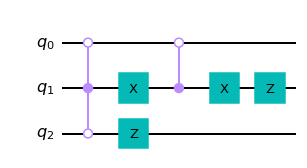

In [3]:
from qiskit.circuit.library import PhaseOracle
oracle = PhaseOracle.from_dimacs_file('3sat.dimacs')
oracle.draw()

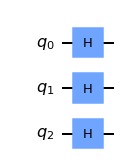

In [4]:
#step 1 of a Grover's search

from qiskit import QuantumCircuit
init = QuantumCircuit(3)
init.h([0,1,2])
init.draw()

In [5]:
# steps 2 & 3 of Grover's algorithm
# the operator includes the oracle and the diffuser

from qiskit.circuit.library import GroverOperator
grover_operator = GroverOperator(oracle)

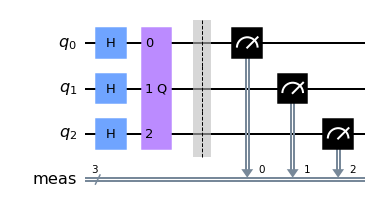

In [6]:
qc = init.compose(grover_operator)
qc.measure_all()
qc.draw()

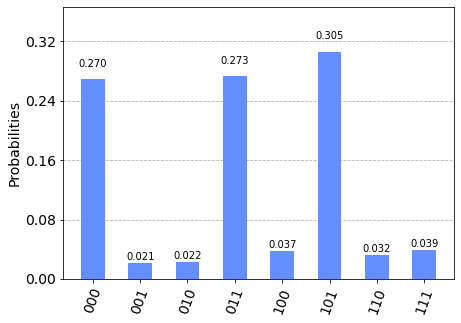

In [7]:
# Simulate the circuit
t_qc = transpile(qc, sim)
counts = sim.run(t_qc).result().get_counts()

# plot the results
from qiskit.visualization import plot_histogram
plot_histogram(counts)

# 2. Grover's Algorithm

## 2.1: The Oracle

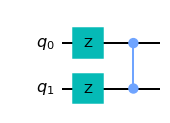

In [10]:
oracle = QuantumCircuit(2)
oracle.z(0) # use compbinations of z on q0 and q1 to change the oracle
oracle.z(1) # in identifying one of (00, 01, 10, 11) states
oracle.cz(0,1) # invert phase of |11>
oracle.draw()

In [11]:
def display_unitary(qc, prefix=""):
    """Simulates a simple circuit and display its matrix representation.
    Args:
        qc (QuantumCircuit): The circuit to compile to a unitary matrix
        prefix (str): Optional LaTeX to be displayed before the matrix
    Returns:
        None (displays matrix as side effect)
    """
    from qiskit import Aer
    from qiskit.visualization import array_to_latex
    sim = Aer.get_backend('aer_simulator')
    # Next, we'll create a copy of the circuit and work on
    # that so we don't change anything as a side effect
    qc = qc.copy()
    # Tell the simulator to save the unitary matrix of this circuit
    qc.save_unitary()
    unitary = sim.run(qc).result().get_unitary()
    display(array_to_latex(unitary, prefix=prefix))

display_unitary(oracle, "U_\\text{oracle}=")

<IPython.core.display.Latex object>

## 2.2: The Diffuser

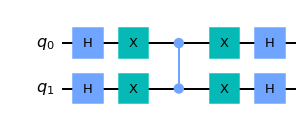

In [12]:
diffuser = QuantumCircuit(2)

diffuser.h([0,1]) #from |s> to |00>

diffuser.x([0,1]) # from |00> to |11>

diffuser.cz(0,1) # now the phase shift using |11> state
diffuser.x([0,1]) #reverse
diffuser.h([0,1]) #reverse

diffuser.draw()

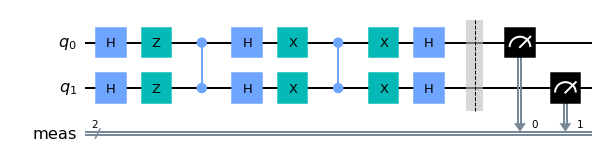

In [13]:
# the complete search circuit

grover = QuantumCircuit(2)
grover.h([0,1])  # initialise |s>
grover = grover.compose(oracle)
grover = grover.compose(diffuser)
grover.measure_all()
grover.draw()

In [14]:
sim.run(grover).result().get_counts()

# to do: Schoning + Grover

{'00': 1024}

# 3. Clean Quantum Computation of a Function

## 3.1: A circuit that computes classical q<sub>0</sub>∧q<sub>1</sub>∧q<sub>2</sub>

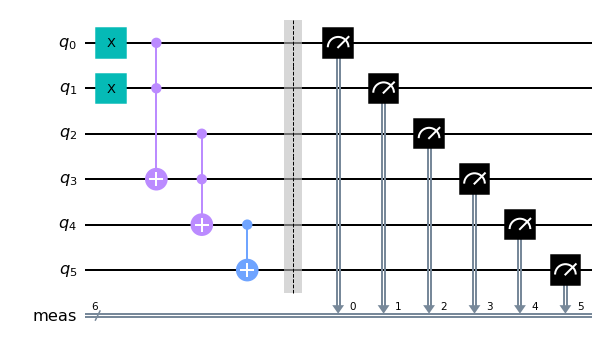

In [18]:
and3 = QuantumCircuit(6)

and3.x(0)
and3.x(1)
#and3.x(2)

and3.toffoli(0,1,3)
and3.toffoli(2,3,4)
and3.cnot(4,5)

and3.measure_all()
and3.draw()

In [19]:
sim.run(and3).result().get_counts()

{'001011': 1024}

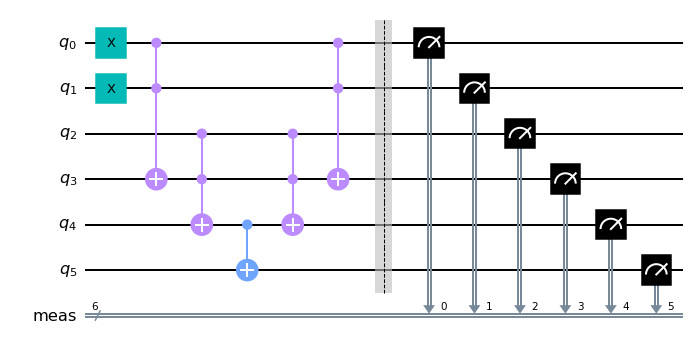

In [24]:
# clean version of the same circuit

clean_and3 = QuantumCircuit(6)

clean_and3.x(0)
clean_and3.x(1)
#clean_and3.x(2)

clean_and3.toffoli(0,1,3)
clean_and3.toffoli(2,3,4)
clean_and3.cnot(4,5) # copy the result
clean_and3.toffoli(2,3,4) # uncomputation
clean_and3.toffoli(0,1,3) # uncomputation

clean_and3.measure_all()
clean_and3.draw()

In [25]:
sim.run(clean_and3).result().get_counts()

{'000011': 1024}

## 3.2: A circuit that computes classical q<sub>0</sub>∨q<sub>1</sub>

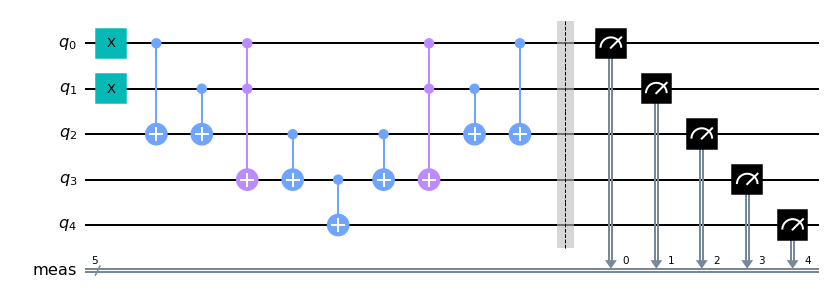

In [26]:
# clean version of the the or2 circuit
# ideally there should only be  4 qubits, computation consisting of 3 qubits

clean_or2 = QuantumCircuit(5)

clean_or2.x(0)
clean_or2.x(1)

clean_or2.cx(0,2)
clean_or2.cx(1,2)
clean_or2.ccx(0,1,3)
clean_or2.cx(2,3)
clean_or2.cnot(3,4) # copy the result
clean_or2.cx(2,3) # uncomputation
clean_or2.ccx(0,1,3) # uncomputation
clean_or2.cx(1,2) # uncomputation
clean_or2.cx(0,2) # uncomputation

clean_or2.measure_all()
clean_or2.draw()

In [27]:
sim.run(clean_or2).result().get_counts()

# to do: or3

{'10011': 1024}